In [1]:

# Importing

import re
import tkinter as tk
from tkinter import ttk, messagebox

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
CSV_PATH = r"E:/Project_CloudThat/12 month+1data.csv"
N_LAGS = 3
FUTURE_MONTHS = [13, 14]


In [5]:
# building functions
def get_product_type(product: str) -> str:
    p = (product or "").lower()
    if "phone" in p:
        return "Phone"
    elif "headphone" in p or "ear" in p:
        return "Audio"
    elif "charger" in p or "cable" in p:
        return "Accessory"
    elif "monitor" in p or "screen" in p:
        return "Display"
    elif "macbook" in p or "laptop" in p:
        return "Laptop"
    elif "keyboard" in p or "mouse" in p:
        return "Input"
    else:
        return "Other"


CITY_RE = re.compile(r",\s*([A-Za-z\s\.-]+)\s*\d{5}$")  # ", City 12345"

def derive_city_if_missing(df: pd.DataFrame) -> pd.DataFrame:
    if "City" in df.columns:
        return df
    if "Purchase Address" in df.columns:
        def extract_city(addr):
            if not isinstance(addr, str):
                return np.nan
            # Common forms: "123 Main St, San Francisco, CA 94016"
            # If dataset already had "City" in another style, adjust as needed:
            parts = [a.strip() for a in addr.split(",")]
            if len(parts) >= 3:
                return parts[-2]  # city usually before "State ZIP"
            # fallback regex
            m = CITY_RE.search(addr)
            return m.group(1).strip() if m else np.nan
        df["City"] = df["Purchase Address"].apply(extract_city)
    else:
        df["City"] = "Unknown"
    return df


def load_and_prepare(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df = df.drop_duplicates()
    # Dates
    df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
    df = df.dropna(subset=["Order Date"])
    # Product cleanup
    df["Product"] = df["Product"].astype(str).str.strip().str.title()
    # City ensure
    df = derive_city_if_missing(df)
    # Month and total
    df["Month"] = df["Order Date"].dt.month
    df["Total Price"] = df["Quantity Ordered"] * df["Price Each"]
    # Product Type
    df["Product Type"] = df["Product"].apply(get_product_type)
    # Keep only months 1–12 (if any noise)
    df = df[df["Month"].between(1, 12)]
    return df


def build_pivot(df: pd.DataFrame, city: str) -> pd.DataFrame:
    """Return pivot with index=Month and columns=Product Type (sums)."""
    if city != "All Cities":
        df = df[df["City"] == city]
    monthly_sales = (
        df.groupby(["Month", "Product Type"], as_index=False)["Total Price"].sum()
    )
    pivot = (
        monthly_sales.pivot(index="Month", columns="Product Type", values="Total Price")
        .sort_index()
        .fillna(0.0)
    )
    # Ensure months 1..12 exist (fill with 0 if not present)
    all_months = pd.Index(range(1, 13), name="Month")
    pivot = pivot.reindex(all_months, fill_value=0.0)
    return pivot


def make_supervised_from_pivot(pivot: pd.DataFrame, n_lags: int):
    """Create X, y from pivot where y is multi-output (all product types)."""
    df_reset = pivot.reset_index()  # Month becomes a col
    cols = pivot.columns
    X, y = [], []
    for i in range(n_lags, len(df_reset)):
        lagged = df_reset.iloc[i - n_lags : i][cols].values.flatten()
        current_month = [int(df_reset.loc[i, "Month"])]
        X.append(np.concatenate([lagged, current_month]))
        y.append(df_reset.iloc[i][cols].values)
    X = np.array(X)
    y = np.array(y)
    return df_reset, cols, X, y


def train_and_forecast(pivot: pd.DataFrame, cols, X, y, n_lags: int, future_months):
    """Train RF, evaluate (last 2 rows as test), forecast future_months."""
    if len(X) < 3:
        raise ValueError("Not enough history after lagging to train. Reduce N_LAGS or add data.")

    # Simple split: last 2 samples = test
    X_train, y_train = X[:-2], y[:-2]
    X_test, y_test = X[-2:], y[-2:]

    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred, multioutput="uniform_average")
    r2 = r2_score(y_test, y_pred, multioutput="uniform_average")

    # Rolling future
    # Start with last n_lags months (actual)
    df_reset = pivot.reset_index()
    input_data = df_reset.iloc[-n_lags:][cols].values.flatten()

    future_predictions = []
    for m in future_months:
        features = np.concatenate((input_data[-n_lags * len(cols) :], [m]))
        pred = rf.predict([features])[0]
        future_predictions.append(pred)
        input_data = np.concatenate((input_data, pred))

    future_df = pd.DataFrame(future_predictions, columns=cols, index=future_months)
    future_df.index.name = "Month"
    future_df = future_df.round(2)
    return rf, (mse, r2), future_df


def build_full_series(pivot: pd.DataFrame, future_df: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([pivot, future_df], axis=0)




In [7]:

# UI App

class ForecastApp(tk.Tk):
    def __init__(self, df):
        super().__init__()
        self.title("📈 Product Sales Forecast Viewer")
        self.geometry("900x640")

        self.df = df
        self.cities = ["All Cities"] + sorted(self.df["City"].dropna().unique().tolist())

        # Top controls
        top_frame = tk.Frame(self)
        top_frame.pack(padx=10, pady=10, fill="x")

        # City dropdown
        tk.Label(top_frame, text="City:", font=("Arial", 11)).pack(side="left", padx=(0, 6))
        self.selected_city = tk.StringVar(value=self.cities[0])
        self.city_dd = ttk.Combobox(top_frame, textvariable=self.selected_city,
                                    values=self.cities, state="readonly", width=28)
        self.city_dd.pack(side="left", padx=(0, 20))

        # Product type dropdown (will be filled after pivot is built)
        tk.Label(top_frame, text="Product Type:", font=("Arial", 11)).pack(side="left", padx=(0, 6))
        self.selected_ptype = tk.StringVar(value="All Types")
        self.ptype_dd = ttk.Combobox(top_frame, textvariable=self.selected_ptype,
                                     values=["All Types"], state="readonly", width=28)
        self.ptype_dd.pack(side="left", padx=(0, 20))

        # Buttons
        self.btn_refresh = tk.Button(top_frame, text="Refresh & Train", font=("Arial", 11),
                                     command=self.refresh_and_train)
        self.btn_refresh.pack(side="left", padx=(0, 10))

        self.btn_plot = tk.Button(top_frame, text="Show Chart", font=("Arial", 11),
                                  command=self.plot_chart)
        self.btn_plot.pack(side="left")

        # Metrics label
        self.metrics_var = tk.StringVar(value="Metrics: —")
        tk.Label(self, textvariable=self.metrics_var, font=("Arial", 10)).pack(pady=(0, 6))

        # Canvas
        self.canvas = None

        # Data placeholders
        self.pivot = None
        self.cols = None
        self.full_sales = None
        self.future_df = None
        self.metrics = None

        # Initial build
        self.refresh_and_train()

        # When city changes, rebuild
        self.city_dd.bind("<<ComboboxSelected>>", lambda e: self.refresh_and_train())
        # When product type changes, re-plot
        self.ptype_dd.bind("<<ComboboxSelected>>", lambda e: self.plot_chart())

    def refresh_and_train(self):
        try:
            # Build pivot for selected city
            city = self.selected_city.get()
            self.pivot = build_pivot(self.df, city)
            df_reset, cols, X, y = make_supervised_from_pivot(self.pivot, N_LAGS)
            self.cols = cols

            # Update product-type dropdown
            ptypes = ["All Types"] + [c for c in cols]
            current_choice = self.selected_ptype.get()
            if current_choice not in ptypes:
                self.selected_ptype.set("All Types")
            self.ptype_dd.config(values=ptypes)

            # Train + forecast
            _, metrics, self.future_df = train_and_forecast(self.pivot, cols, X, y, N_LAGS, FUTURE_MONTHS)
            self.full_sales = build_full_series(self.pivot, self.future_df)
            self.metrics = metrics
            self.metrics_var.set(f"Metrics (last 2 samples):  MSE={metrics[0]:.2f} | R²={metrics[1]:.3f}")
            self.plot_chart()
        except Exception as e:
            messagebox.showerror("Error", str(e))

    def plot_chart(self):
        # Clear old canvas
        if self.canvas:
            self.canvas.get_tk_widget().destroy()
            self.canvas = None

        if self.full_sales is None:
            return

        product_choice = self.selected_ptype.get()

        fig, ax = plt.subplots(figsize=(9, 5))
        if product_choice == "All Types":
            for col in self.full_sales.columns:
                ax.plot(self.full_sales.index, self.full_sales[col], marker='o', label=col)
            ax.legend(title="Product Type", bbox_to_anchor=(1.02, 1), loc="upper left")
            ax.set_title(f"Monthly Sales Trend + Forecast (Months 1–{max(self.full_sales.index)})")
        else:
            ax.plot(self.full_sales.index, self.full_sales[product_choice], marker='o')
            ax.set_title(f"Monthly Sales Trend + Forecast: {product_choice}")

        ax.set_xlabel("Month")
        ax.set_ylabel("Total Sales ($)")
        ax.grid(True)
        plt.tight_layout()

        self.canvas = FigureCanvasTkAgg(fig, master=self)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(pady=10)





C:\Users\DELL-PC\AppData\Local\Temp\ipykernel_2752\3220057688.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")


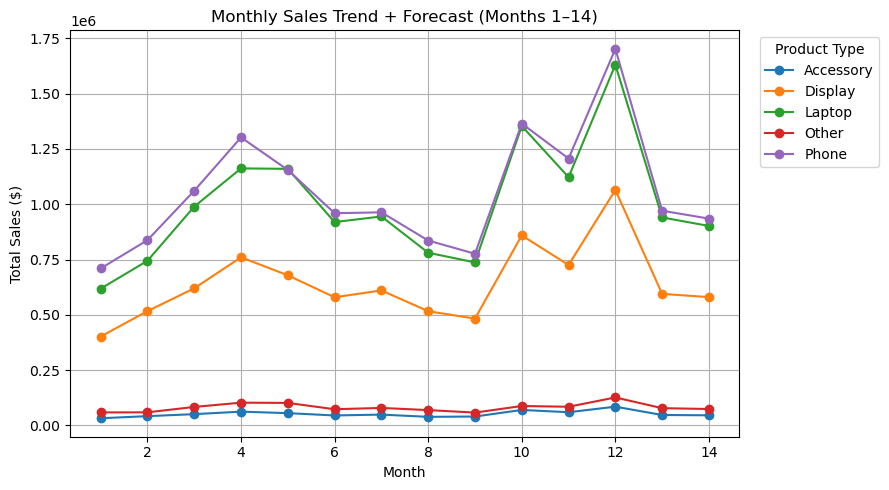

In [9]:
# Main

if __name__ == "__main__":
    try:
        data = load_and_prepare(CSV_PATH)
    except Exception as e:
        raise SystemExit(f"Failed to load data: {e}")

    app = ForecastApp(data)
    app.mainloop()